In [2]:
import pandas as pd

def normalize_data(path: str, header: int = 10, nrows: int | None = None):
  df = pd.read_csv(path, header=header, index_col=0, nrows=nrows)
  df.columns = df.columns.astype(int).astype(str)
  for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
  return df

In [3]:
gdp = normalize_data("./data/sg_gdp_in_chained_by_industry.csv").iloc[0, :]
gdp = gdp["2024": "1990"].sort_index()


In [4]:
net_capital_stock = normalize_data("./data/sg_net_capital_stock.csv").loc["Total"]
net_capital_stock = net_capital_stock["2024": "1990"].sort_index()

In [5]:
workers = normalize_data("./data/sg_labor_force.csv", header=9).drop("2025", axis=1).iloc[0, :] * 1000
workers = workers["2024": "1990"].sort_index()

hours = normalize_data("./data/sg_working_hours.csv").loc["Total"].sort_index() * 52.143
hours

1990    2424.6495
1991    2429.8638
1992    2429.8638
1993    2435.0781
1994    2445.5067
1995    2455.9353
1996    2461.1496
1997    2466.3639
1998    2435.0781
1999    2440.2924
2000    2450.7210
2001    2409.0066
2002    2398.5780
2003    2398.5780
2004    2414.2209
2005    2424.6495
2006    2409.0066
2007    2414.2209
2008    2414.2209
2009    2398.5780
2010    2409.0066
2011    2409.0066
2012    2409.0066
2013    2409.0066
2014    2398.5780
2015    2377.7208
2016    2372.5065
2017    2351.6493
2018    2336.0064
2019    2330.7921
2020    2294.2920
2021    2304.7206
2022    2299.5063
2023    2273.4348
2024    2257.7919
Name: Total, dtype: float64

In [6]:
income_share = normalize_data("./data/sg_income_share_of_gdp.csv", nrows=3)
labor_distribution = income_share.loc["Compensation Of Employees"] / (
  income_share.loc["Compensation Of Employees"] + 
  income_share.loc["Gross Operating Surplus"] + 
  income_share.loc["Taxes Less Subsidies On Production & On Imports"]
)
labor_distribution = labor_distribution["2024":"1990"].sort_index()


<Figure size 1000x600 with 0 Axes>

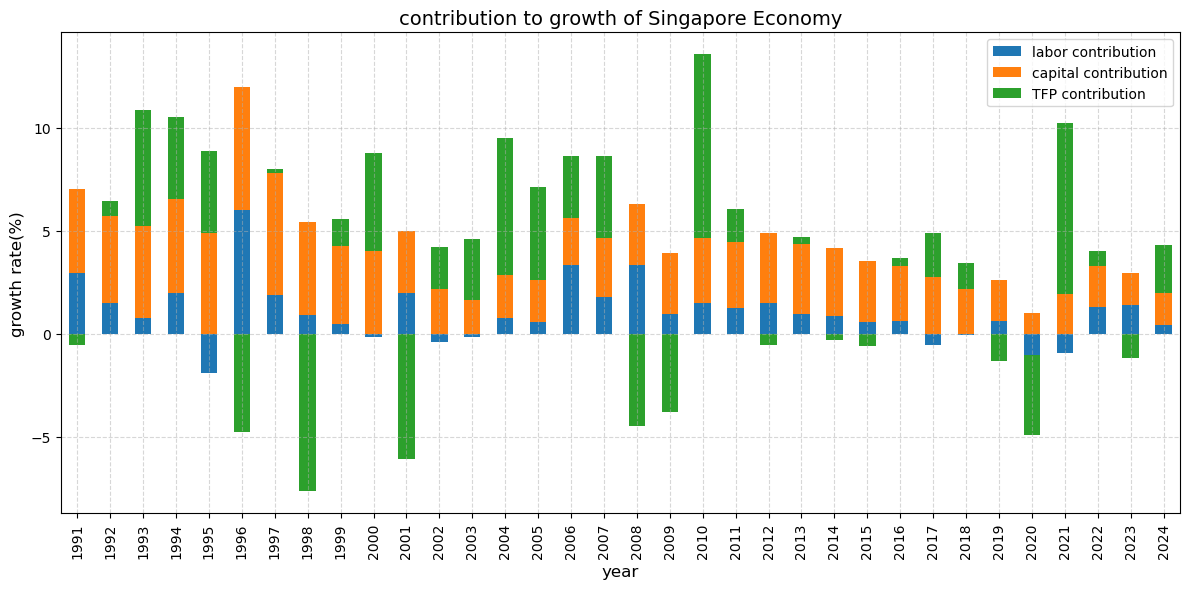

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Y = gdp
K = net_capital_stock
L = workers * hours
labor_share = labor_distribution
alpha = 1 - labor_share  # 資本分配率

gY = np.log(Y).diff().dropna()
gK = np.log(K).diff().dropna()
gL = np.log(L).diff().dropna()
gA = gY - ((1 - alpha) * gL + alpha * gK)

# 成長寄与度を計算（単位：%）
labor_contrib = (1 - alpha) * gL * 100
capital_contrib = alpha * gK * 100
tfp_contrib = gA * 100

# データをまとめる
contrib_df = pd.DataFrame({
    'labor contribution': labor_contrib,
    'capital contribution': capital_contrib,
    'TFP contribution': tfp_contrib,
}, index=Y.index).dropna()

# プロット
plt.figure(figsize=(10,6))
contrib_df.plot(kind='bar', stacked=True, figsize=(12,6))

plt.title("contribution to growth of Singapore Economy", fontsize=14)
plt.xlabel("year", fontsize=12)
plt.ylabel("growth rate(%)", fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
